In [13]:
from pathlib import Path
import polars as pl
import json
from IPython import display
from scipy import stats
import gzip
import pickle
import arviz as az
from matplotlib import pyplot as plt
import seaborn as sns
from cogmood_analysis.load import unpack_results, load_flkr_results
pl.Config(tbl_rows=300, tbl_cols=300)

In [3]:
rhat_thresh = 1.1
simple_keys = ['subject', 'model', 'time_start', 'time_end', 'max_rhat', 'min_ess', 'max_mcse', 'sub_score', 'map_mean', 'post_mean', 'map_std', 'post_std', 'map_proportion', 'posterior_proportion']
nested_keys = ['map_dict', 'rhat_dict', 'ess_dict', 'mcse_dict']

def make_commands(model, subjects, cleaned_dir, to_model_dir, results_dir, seed=None, mode_init=False, overwrite=False):
    cmds = []
    bad_subs = []
    for subj in subjects:
        subj_cleaned_dir = cleaned_dir / subj
        cleaned_pickle = subj_cleaned_dir / f'{model}.pkl'
        task_csv = to_model_dir / f'{model}-{subj}.csv'
        if (not task_csv.exists()):
            print(f"Subject {subj} missing required files")
            bad_subs.append(subj)
            continue
    
        # the below if allows this cell to be rerun to re-run failed jobs
        out_dict = results_dir / f'{model}_results_dict_{subj}.json'
        #print(subj, out_dict.exists(), out_dict.as_posix())
        if overwrite or not out_dict.exists():
            cmd = f'cd {code_dir} ' \
                   ' && export JAX_NUM_CPU_DEVICES=8'
            if overwrite or not cleaned_pickle.exists():
                  cmd += f' && uv run python -m {model}.{model}_data_prep "{subj}" "{task_csv}" "{subj_cleaned_dir.as_posix()}" '

            cmd += f'&& uv run python -m {model}.{model}_subj_fit '
            if seed is not None:
                cmd += f'-seed {seed} '
            if mode_init:
                cmd += '-mode-init '
            cmd += f'"{subj}" "{subj_cleaned_dir.as_posix()}" "{results_dir.as_posix()}"'
            
            cmds.append(cmd)
    return cmds, bad_subs

In [4]:
to_model_dir = Path('../data/task/to_model_first100').resolve()
to_model_bc25_dir = Path('../data/task/to_model_bc25_first100').resolve()

cleaned_dir = Path('../data/task/data_cleaned_first100').resolve()
cleaned_dir.mkdir(exist_ok=True)
cleaned_bc25_dir = Path('../data/task/data_cleaned_bc25_first100').resolve()
cleaned_bc25_dir.mkdir(exist_ok=True)

# lots of directories for storing results from different model fit settings
# this are in order in which they are run, only participants who 
# failed to converge (max_rhat > 1.1) in one step are run in the subsequent step
results_dir = Path('../data/task/model_res_first100').resolve()
results_dir.mkdir(exist_ok=True)
results_bc25_dir = Path('../data/task/model_res_bc25_first100').resolve()
results_bc25_dir.mkdir(exist_ok=True)
results_seed_dir = Path('../data/task/model_res_bc25seed_first100').resolve()
results_seed_dir.mkdir(exist_ok=True)
results_modep_dir = Path('../data/task/model_res_bc25modeprior_first100').resolve()
results_modep_dir.mkdir(exist_ok=True)

code_dir = Path("../packages/SupremePilot/").resolve()
swarm_dir = Path('../swarm/').resolve()
swarm_dir.mkdir(exist_ok=True)
swarm_cmds = swarm_dir / 'swarm_commands'
swarm_cmds.mkdir(exist_ok=True)
swarm_logs = swarm_dir / 'swarm_logs'
swarm_logs.mkdir(exist_ok=True)

In [5]:
dq = pl.read_csv(to_model_dir / 'data_quality.csv')
subjects = dq['sub_id'].to_list()

# First round of model fitting

## Run CAB model

In [285]:
model = 'cab'
cab_cmds, cab_bad_subs = make_commands(model, subjects, cleaned_dir, to_model_dir, results_dir)
print(len(cab_cmds))

1


In [286]:
cab_cmds

['cd /vf/users/MLDSST/nielsond/cogmood/analysis/cogmood_analysis/packages/SupremePilot  && export JAX_NUM_CPU_DEVICES=8&& uv run python -m cab.cab_subj_fit "kqu8e4ozsugvkiszq7dgedhg" "/vf/users/MLDSST/nielsond/cogmood/analysis/cogmood_analysis/data/task/data_cleaned_first100/kqu8e4ozsugvkiszq7dgedhg" "/vf/users/MLDSST/nielsond/cogmood/analysis/cogmood_analysis/data/task/model_res_first100"']

In [287]:
swarm_file = swarm_dir / f'{model}_cmds_f100'
swarm_file.write_text('\n'.join(cab_cmds))
!swarm -g 5 -t 10 -J cab_f100 --log {swarm_logs} --partition quick --time 01:00:00 {swarm_file}

11954414


## Run RDM

In [49]:
model = 'rdm'
rdm_cmds, rdm_bad_subs = make_commands(model, subjects, cleaned_dir, to_model_dir, results_dir)
print(len(rdm_cmds))


0


In [30]:
swarm_file = swarm_dir / f'{model}_cmds_f100'
swarm_file.write_text('\n'.join(rdm_cmds))
!swarm -g 5 -t 10 -J rdm_f100 --log {swarm_logs} --partition quick --time 00:30:00 {swarm_file}

11533527


## Run BART

In [23]:
model = 'bart'
bart_cmds, bart_bad_subs = make_commands(model, subjects, cleaned_dir, to_model_dir, results_dir)
print(len(bart_cmds))


0


In [ ]:
swarm_file = swarm_dir / f'{model}_cmds_f100'
swarm_file.write_text('\n'.join(bart_cmds))
!swarm -g 5 -t 10 -b 5 -J bart_f100 --log {swarm_logs} --partition quick --time 00:05:00 {swarm_file}

# Check outputs and rerun

## BART

In [198]:
bart_jsons = sorted(results_dir.glob('bart_results_dict_*.json'))
bart_dat = []
for bj in bart_jsons:
    bjj = json.loads(bj.read_text())
    row = unpack_results(bjj, simple_keys, nested_keys)
    bart_dat.append(row)
bart_dat = pl.DataFrame(bart_dat)

In [199]:
bart_dat['max_rhat'].max()

1.0148992865704851

No need to rerun anything, max rhat is below 1.1

In [201]:
results_dir

PosixPath('/vf/users/MLDSST/nielsond/cogmood/analysis/cogmood_analysis/data/task/model_res_first100')

In [200]:
bart_dat.write_csv(results_dir.parent / 'bart_results.csv')

## RDM

In [258]:
rdm_jsons = sorted(results_dir.glob('rdm_results_dict_*.json'))
rdm_dat = []
for rj in rdm_jsons:
    rjj = json.loads(rj.read_text())
    row = unpack_results(rjj, simple_keys, nested_keys)
    # row['n_divergences'] = az.from_netcdf(results_dir / f"rdm_arviz_{row['subject']}.nc").sample_stats.diverging.values.flatten().sum()
    rdm_dat.append(row)
rdm_dat = pl.DataFrame(rdm_dat).with_columns(
    recovery_step=0
)
print(len(rdm_dat))

100


In [207]:
rdm_cf = rdm_dat.filter(pl.col('max_rhat') >= rhat_thresh)
rdm_cf

subject,model,time_start,time_end,max_rhat,min_ess,max_mcse,sub_score,map_mean,post_mean,map_std,post_std,map_proportion,posterior_proportion,map__v0,map__w_d,map__w_s,map__t0,map__sigma,map__sigma_timer,map__v_timer,rhat__v0,rhat__w_d,rhat__w_s,rhat__t0,rhat__sigma,rhat__sigma_timer,rhat__v_timer,ess__v0,ess__w_d,ess__w_s,ess__t0,ess__sigma,ess__sigma_timer,ess__v_timer,mcse__v0,mcse__w_d,mcse__w_s,mcse__t0,mcse__sigma,mcse__sigma_timer,mcse__v_timer,init
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""3syjaj2fx9w8fj87yjhu00p7""","""rdm""","""2026-02-11 20:11:57.156466+00:…","""2026-02-11 20:14:47.109239+00:…",1.694209,12.397405,0.177465,6.178659,9.214089,6.183871,3.509651,5.138807,0.18,0.481583,0.66147,0.861891,0.412265,0.026119,0.296678,1.304977,0.911492,1.592323,1.116019,1.169092,1.001344,1.694193,1.694209,1.222127,13.397589,399.861126,12809.230919,9241.191118,12.421479,12.397405,10320.29243,0.122649,0.030934,0.005954,0.000118,0.16429,0.177465,0.004925,"""default"""
"""9nikskgjka594s7gezqz18je""","""rdm""","""2026-02-11 20:12:06.677274+00:…","""2026-02-11 20:16:23.463067+00:…",1.641444,12.834745,1.629,13.944758,-0.860699,3.588482,2.750727,6.0312,1.0,0.944625,-10.870266,-8.319239,-7.006762,0.00039,2.640577,0.43133,0.805279,1.641272,1.200863,1.291939,1.191487,1.641032,1.641163,1.641444,12.871885,26.90579,20.573474,27.912357,12.8597,12.834745,12.836223,1.629,0.634822,0.793443,0.000223,0.346391,0.154598,0.13373,"""default"""
"""g3aplt95sbh2wq9hb4y8ludy""","""rdm""","""2026-02-11 20:11:52.423499+00:…","""2026-02-11 20:22:08.199590+00:…",1.217379,26.170582,0.046392,20.862917,19.663225,19.403879,1.28196,1.748153,0.825,0.792708,0.332449,1.032062,0.197167,0.209862,0.200497,0.099606,0.426302,1.087909,1.060529,1.07224,1.067556,1.064016,1.217379,1.039173,625.785724,88.46354,613.303899,79.633204,84.053895,26.170582,168.964923,0.002154,0.046392,0.004498,0.022642,0.006383,0.003517,0.004218,"""default"""
"""ie4mxel1c4ndkrb4y51xveqj""","""rdm""","""2026-02-11 20:11:59.201672+00:…","""2026-02-11 20:14:56.470449+00:…",1.499554,14.700459,0.07549,10.534322,8.030295,8.174884,2.564171,3.430561,0.835,0.752583,0.389446,0.52053,0.134272,0.000456,0.213539,0.613155,0.542646,1.413655,1.192955,1.149946,1.003416,1.499343,1.499554,1.183859,16.396251,28.091693,34.882356,8336.164113,14.707451,14.700459,69.772768,0.048085,0.051955,0.054761,0.000131,0.05377,0.07549,0.019262,"""default"""
"""jrgj80rw8xkztj3bliqsh8u6""","""rdm""","""2026-02-11 20:12:02.803338+00:…","""2026-02-11 20:14:55.365419+00:…",1.29514,20.439236,0.4728,6.441778,-0.320306,0.705821,2.617097,3.4599,1.0,0.9305,-4.253682,-0.727346,0.699158,0.359232,1.539523,0.364632,0.895704,1.295025,1.048732,1.181432,1.273569,1.295059,1.29514,1.294772,20.511276,1917.795959,14443.209085,21.646712,20.500033,20.545512,20.439236,0.4728,0.043109,0.017152,0.022116,0.136417,0.033587,0.083387,"""default"""
"""ptt94y1gipwmsxcoxfwybjrm""","""rdm""","""2026-02-11 20:12:02.227545+00:…","""2026-02-11 20:24:00.278299+00:…",1.409624,16.848804,0.066083,17.429235,15.988728,16.272865,1.909858,2.55157,0.76,0.669542,0.288619,1.097793,0.34217,0.078598,0.427878,0.099372,0.419603,1.106609,1.042806,1.088969,1.035969,1.285538,1.409624,1.235719,49.768143,515.64266,92.93524,775.398082,22.163696,16.848804,25.160946,0.011802,0.009049,0.020663,0.003575,0.015717,0.066083,0.030001,"""default"""


In [204]:
model = 'rdm'
rdm_sub_eval = [
    {'subject': '3syjaj2fx9w8fj87yjhu00p7', 'keep': False, 'reason': 'poor performance in third block'},
    {'subject': '9nikskgjka594s7gezqz18je', 'keep': False, 'reason': 'poor performance on high coherence difference'},
    {'subject': 'g3aplt95sbh2wq9hb4y8ludy', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'ie4mxel1c4ndkrb4y51xveqj', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'jrgj80rw8xkztj3bliqsh8u6', 'keep': False, 'reason': 'low performance on everything but high coherence difference'},
    {'subject': 'ptt94y1gipwmsxcoxfwybjrm', 'keep': True, 'reason': 'acceptable performance and one bad chain, but rt curve may be a little bit too flat'},
]
rdm_sub_eval = pl.DataFrame(rdm_sub_eval)
for subject in rdm_cf['subject'].to_list():
    if not subject in rdm_sub_eval['subject']:
        sub_rdm = pl.read_csv(to_model_dir / f'{model}-{subject}.csv').with_columns(
            coh_dif = (pl.col('left_coherence') - pl.col('right_coherence')).abs()
        )
        print(subject, flush=True)
        display.display(sub_rdm.select(['run_num', 'correct', 'rt']).group_by('run_num').mean().sort('run_num'))
        display.display(sub_rdm.select([ 'coh_dif', 'correct', 'rt']).group_by(['coh_dif']).mean().sort([ 'coh_dif']))
        print(flush=True)

In [53]:
rdm_for_bc25 = rdm_sub_eval.filter(pl.col('keep'))['subject'].to_list()

In [54]:
rdm_for_bc25

['g3aplt95sbh2wq9hb4y8ludy',
 'ie4mxel1c4ndkrb4y51xveqj',
 'ptt94y1gipwmsxcoxfwybjrm']

### box-cox threshold of 2.5

In [55]:
model = 'rdm'
rdm_cmds, rdm_bad_subs = make_commands(model, rdm_for_bc25, cleaned_bc25_dir, to_model_bc25_dir, results_bc25_dir)
print(len(rdm_cmds))

0


In [47]:
swarm_file = swarm_dir / f'{model}_cmds_f100'
swarm_file.write_text('\n'.join(rdm_cmds))
!swarm -g 5 -t 10 -J rdm_f100 --log {swarm_logs} --partition quick --time 00:30:00 {swarm_file}

11535092


In [259]:
rdm_bc25_jsons = sorted(results_bc25_dir.glob('rdm_results_dict_*.json'))
rdm_bc25_dat = []
for rj in rdm_bc25_jsons:
    rjj = json.loads(rj.read_text())
    row = unpack_results(rjj, simple_keys, nested_keys)
    rdm_bc25_dat.append(row)
rdm_bc25_dat = pl.DataFrame(rdm_bc25_dat).with_columns(
    recovery_step = pl.lit(1)
)
rdm_bc25_dat

subject,model,time_start,time_end,max_rhat,min_ess,max_mcse,sub_score,map_mean,post_mean,map_std,post_std,map_proportion,posterior_proportion,map__v0,map__w_d,map__w_s,map__t0,map__sigma,map__sigma_timer,map__v_timer,rhat__v0,rhat__w_d,rhat__w_s,rhat__t0,rhat__sigma,rhat__sigma_timer,rhat__v_timer,ess__v0,ess__w_d,ess__w_s,ess__t0,ess__sigma,ess__sigma_timer,ess__v_timer,mcse__v0,mcse__w_d,mcse__w_s,mcse__t0,mcse__sigma,mcse__sigma_timer,mcse__v_timer,recovery_step
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""g3aplt95sbh2wq9hb4y8ludy""","""rdm""","""2026-02-11 20:31:52.429203+00:…","""2026-02-11 20:43:05.719000+00:…",1.217379,26.170582,0.046392,20.862917,19.663225,19.403879,1.28196,1.748153,0.825,0.792708,0.332449,1.032062,0.197167,0.209862,0.200497,0.099606,0.426302,1.087909,1.060529,1.07224,1.067556,1.064016,1.217379,1.039173,625.785724,88.46354,613.303899,79.633204,84.053895,26.170582,168.964923,0.002154,0.046392,0.004498,0.022642,0.006383,0.003517,0.004218,1
"""ie4mxel1c4ndkrb4y51xveqj""","""rdm""","""2026-02-11 20:31:52.701793+00:…","""2026-02-11 20:36:03.312474+00:…",1.499554,14.700459,0.07549,10.534322,8.030295,8.174884,2.564171,3.430561,0.835,0.752583,0.389446,0.52053,0.134272,0.000456,0.213539,0.613155,0.542646,1.413655,1.192955,1.149946,1.003416,1.499343,1.499554,1.183859,16.396251,28.091693,34.882356,8336.164113,14.707451,14.700459,69.772768,0.048085,0.051955,0.054761,0.000131,0.05377,0.07549,0.019262,1
"""ptt94y1gipwmsxcoxfwybjrm""","""rdm""","""2026-02-11 20:31:52.432056+00:…","""2026-02-11 20:40:01.411808+00:…",1.409624,16.848804,0.066083,17.429235,15.988728,16.272865,1.909858,2.55157,0.76,0.669542,0.288619,1.097793,0.34217,0.078598,0.427878,0.099372,0.419603,1.106609,1.042806,1.088969,1.035969,1.285538,1.409624,1.235719,49.768143,515.64266,92.93524,775.398082,22.163696,16.848804,25.160946,0.011802,0.009049,0.020663,0.003575,0.015717,0.066083,0.030001,1


In [210]:
rdm_for_bc25seed = rdm_bc25_dat['subject'].to_numpy()
rdm_for_bc25seed

array(['g3aplt95sbh2wq9hb4y8ludy', 'ie4mxel1c4ndkrb4y51xveqj',
       'ptt94y1gipwmsxcoxfwybjrm'], dtype=object)

### box-cox 2.5 + new seed

In [58]:
model = 'rdm'
rdm_cmds, rdm_bad_subs = make_commands(model, rdm_for_bc25, cleaned_bc25_dir, to_model_bc25_dir, results_seed_dir, seed=624183629888)
print(len(rdm_cmds))

3


In [59]:
swarm_file = swarm_dir / f'{model}_cmds_f100'
swarm_file.write_text('\n'.join(rdm_cmds))
!swarm -g 5 -t 10 -J rdm_f100 --log {swarm_logs} --partition quick --time 00:30:00 {swarm_file}

11535991


In [260]:
rdm_bc25seed_jsons = sorted(results_seed_dir.glob('rdm_results_dict_*.json'))
rdm_bc25seed_dat = []
for rj in rdm_bc25seed_jsons:
    rjj = json.loads(rj.read_text())
    row = unpack_results(rjj, simple_keys, nested_keys)
    rdm_bc25seed_dat.append(row)
rdm_bc25seed_dat = pl.DataFrame(rdm_bc25seed_dat).with_columns(
    recovery_step = pl.lit(2)
)
rdm_bc25seed_dat

subject,model,time_start,time_end,max_rhat,min_ess,max_mcse,sub_score,map_mean,post_mean,map_std,post_std,map_proportion,posterior_proportion,map__v0,map__w_d,map__w_s,map__t0,map__sigma,map__sigma_timer,map__v_timer,rhat__v0,rhat__w_d,rhat__w_s,rhat__t0,rhat__sigma,rhat__sigma_timer,rhat__v_timer,ess__v0,ess__w_d,ess__w_s,ess__t0,ess__sigma,ess__sigma_timer,ess__v_timer,mcse__v0,mcse__w_d,mcse__w_s,mcse__t0,mcse__sigma,mcse__sigma_timer,mcse__v_timer,recovery_step
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""g3aplt95sbh2wq9hb4y8ludy""","""rdm""","""2026-02-11 21:03:24.079982+00:…","""2026-02-11 21:14:15.128382+00:…",1.303611,20.361329,0.031238,20.862917,19.357288,19.481592,1.290056,1.689069,0.905,0.791333,0.357824,0.97685,0.136436,0.203926,0.198598,0.100278,0.426906,1.132897,1.099958,1.303611,1.107877,1.159181,1.153233,1.165376,39.30598,115.228026,20.361329,109.432248,129.365013,37.013107,106.889979,0.007606,0.031238,0.026924,0.015404,0.003952,0.003335,0.005227,2
"""ie4mxel1c4ndkrb4y51xveqj""","""rdm""","""2026-02-11 21:03:24.083685+00:…","""2026-02-11 21:06:41.783516+00:…",1.753336,12.008279,0.0884,10.534322,7.844109,8.140102,2.36562,3.389772,0.87,0.758958,0.409568,0.48317,0.080133,0.001582,0.216826,0.638887,0.550282,1.593849,1.246052,1.247428,1.008799,1.706738,1.753336,1.220271,13.433178,23.356431,23.121249,4157.181186,12.350249,12.008279,84.070023,0.052148,0.057029,0.066873,0.000264,0.061057,0.0884,0.021628,2
"""ptt94y1gipwmsxcoxfwybjrm""","""rdm""","""2026-02-11 21:03:24.078932+00:…","""2026-02-11 21:07:00.905942+00:…",1.140937,39.991547,0.042396,17.429235,16.948357,16.175589,2.16356,2.564651,0.56,0.680292,0.247288,1.249525,0.451046,0.095282,0.449829,0.097606,0.417804,1.022045,1.02666,1.024555,1.031447,1.103478,1.140937,1.094347,365.503079,249.035158,380.611909,181.875925,53.693212,39.991547,58.424813,0.00397,0.012095,0.009384,0.005959,0.009515,0.042396,0.02017,2


In [212]:
rdm_for_bc25mode = rdm_bc25seed_dat['subject'].to_numpy()
rdm_for_bc25mode

array(['g3aplt95sbh2wq9hb4y8ludy', 'ie4mxel1c4ndkrb4y51xveqj',
       'ptt94y1gipwmsxcoxfwybjrm'], dtype=object)

### box-cox 2.5 + mode

In [61]:
model = 'rdm'
rdm_cmds, rdm_bad_subs = make_commands(model, rdm_for_bc25, cleaned_bc25_dir, to_model_bc25_dir, results_modep_dir, mode_init=True)
print(len(rdm_cmds))

3


In [63]:
swarm_file = swarm_dir / f'{model}_cmds_f100'
swarm_file.write_text('\n'.join(rdm_cmds))
!swarm -g 5 -t 10 -J rdm_f100 --log {swarm_logs} --partition quick --time 00:30:00 {swarm_file}

11537360


In [261]:
rdm_bc25mode_jsons = sorted(results_modep_dir.glob('rdm_results_dict_*.json'))
rdm_bc25mode_dat = []
for rj in rdm_bc25mode_jsons:
    rjj = json.loads(rj.read_text())
    row = unpack_results(rjj, simple_keys, nested_keys)
    # row['n_divergences'] = az.from_netcdf(results_modep_dir / f"rdm_arviz_{row['subject']}.nc").sample_stats.diverging.values.flatten().sum()
    rdm_bc25mode_dat.append(row)
rdm_bc25mode_dat = pl.DataFrame(rdm_bc25mode_dat).with_columns(
    recovery_step = pl.lit(3)
)
rdm_bc25mode_dat

subject,model,time_start,time_end,max_rhat,min_ess,max_mcse,sub_score,map_mean,post_mean,map_std,post_std,map_proportion,posterior_proportion,map__v0,map__w_d,map__w_s,map__t0,map__sigma,map__sigma_timer,map__v_timer,rhat__v0,rhat__w_d,rhat__w_s,rhat__t0,rhat__sigma,rhat__sigma_timer,rhat__v_timer,ess__v0,ess__w_d,ess__w_s,ess__t0,ess__sigma,ess__sigma_timer,ess__v_timer,mcse__v0,mcse__w_d,mcse__w_s,mcse__t0,mcse__sigma,mcse__sigma_timer,mcse__v_timer,recovery_step
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""g3aplt95sbh2wq9hb4y8ludy""","""rdm""","""2026-02-12 14:12:06.986708+00:…","""2026-02-12 14:27:46.864005+00:…",1.130939,47.032399,0.019218,20.862917,19.426123,19.334482,1.315211,1.724742,0.865,0.810292,0.327109,1.06533,0.210551,0.232644,0.205196,0.101307,0.434711,1.121135,1.130939,1.064851,1.059613,1.064917,1.11803,1.063109,140.857526,328.259519,79.957365,260.536953,222.339636,47.032399,306.515277,0.002935,0.019218,0.011193,0.010379,0.003701,0.002966,0.003558,3
"""ie4mxel1c4ndkrb4y51xveqj""","""rdm""","""2026-02-12 14:12:17.084678+00:…","""2026-02-12 14:18:25.495161+00:…",1.001938,4608.668438,0.002568,10.534322,7.973363,8.226209,2.6015,3.265798,0.835,0.759,0.408197,0.488757,0.122402,0.00085,0.229257,0.630787,0.500828,1.001938,1.000463,1.000446,1.000453,1.00053,1.000696,1.001513,7451.972674,9660.682975,6478.746855,8812.315917,5409.520179,5516.945698,4608.668438,0.000776,0.001539,0.002358,0.000128,0.000722,0.000949,0.002568,3
"""ptt94y1gipwmsxcoxfwybjrm""","""rdm""","""2026-02-12 14:11:07.084073+00:…","""2026-02-12 14:17:08.152368+00:…",1.347265,18.296566,0.062848,17.429235,16.340651,16.028875,1.956294,2.581464,0.665,0.699292,0.275301,1.122898,0.376236,0.074906,0.421101,0.113298,0.40922,1.133074,1.089226,1.117466,1.086859,1.274955,1.347265,1.232854,38.688216,56.897791,42.828324,57.136565,21.999571,18.296566,24.385547,0.013234,0.025677,0.02989,0.009978,0.015287,0.062848,0.030257,3


### Build results table

In [351]:
rdm_params = ['v0', 'w_d', 'w_s', 't0', 'sigma', 'sigma_timer', 'v_timer']
rdm_rhat_cols = ['rhat__' + pp for pp in rdm_params]

In [352]:
# implements logic specified in preregistration that we will try to get max rhat under 1.1
# and if we're unable to, we'll take the values from the run that has the fewest 
# parameters with rhats over 1.1
rdm_res = rdm_dat.filter(pl.col('max_rhat') < rhat_thresh).with_columns(
    n_gt_rhat = pl.lit(0)
)
rec_dfs = [rdm_bc25_dat, rdm_bc25seed_dat, rdm_bc25mode_dat]
rdm_recovery = pl.concat(rec_dfs).with_columns(
    pl.sum_horizontal(pl.col(col).gt(rhat_thresh).cast(pl.Int32) for col in rdm_rhat_cols).alias('n_gt_rhat')
)
rdm_recovered = rdm_recovery.sort(['subject', 'n_gt_rhat', 'recovery_step']).group_by('subject').first()
rdm_res = pl.concat([rdm_res, rdm_recovered])
assert len(rdm_jsons) - (~rdm_sub_eval['keep']).sum() == len(rdm_res)
rdm_res.write_csv(results_dir.parent / 'rdm_results.csv')

## CAB

In [14]:
cab_jsons = sorted(results_dir.glob('cab_results_dict_*.json'))
cab_dat = []
for cj in cab_jsons:
    cjj = json.loads(cj.read_text())
    row = unpack_results(cjj, simple_keys, nested_keys)
    cab_dat.append(row)
cab_dat = pl.DataFrame(cab_dat).with_columns(
    recovery_step=0
)
print(len(cab_dat))

100


In [15]:
cab_cf = cab_dat.filter(pl.col('max_rhat') >= rhat_thresh)

In [16]:
model = 'cab'
cab_sub_eval = [
    {'subject': '09r1f0ufan0oecc5n0bkn8cg', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': '4okbolxm9drgj2qzxmrhhm5p', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': '4rgwkrypp8mn69jzw1pia1jj', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': '6xkodkimz1u9k0lvdcodekuy', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': '76asjonvp10021v9uaart0mn', 'keep': True, 'reason': 'acceptable performance and one bad chain, though some other chains are borderline'},
    {'subject': 'aqc7oecqcf7lxlwcc3pwkaih', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'b9209brzu2174wx8wkmbq4j6', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'foahp3g4l3ji9317jmee0qjk', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'ixn4e8k48nz0yfr2ewqculwv', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'kc2uqmfz55xq8jv6t0wpubni', 'keep': False, 'reason': 'acceptable performance and one bad chain, though uniformly low performance on recombined'},
    {'subject': 'klsrxuby3l2267ekm2dn36wz', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'l63h3y9ib21tgrbfp5qzjs1k', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'sfrvmu1h782u4uiyv1plbumz', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'udbspzezvsapcsuzymfknc69', 'keep': False, 'reason': 'acceptable performance more than one chain failure'},
    {'subject': 'ulbrvydu9ndrdhzsoark5r8c', 'keep': True, 'reason': 'acceptable performance, two variant chains, but will try to recover'},
    {'subject': 'ypf97l2yojnfsstaidit4487', 'keep': True, 'reason': 'acceptable performance and one bad chain'},
    {'subject': 'zexqcgvxc55igvmm1iddw4eg', 'keep': True, 'reason': 'acceptable performance and one bad chain'},

]
cab_sub_eval = pl.DataFrame(cab_sub_eval)
for subject in cab_cf['subject'].to_list():
    if not subject in cab_sub_eval['subject']:
        sub_cab = pl.read_csv(to_model_dir / f'{model}-{subject}.csv')
        print(subject, flush=True)
        display.display(
            sub_cab
                .select(['block', 'correct', 'rt'])
                .group_by('block')
                .mean()
                .sort('block')
        )
        display.display(
            sub_cab
                .select([ 'correct', 'rt', 'cond_strength', 'cond_trial'])
                .group_by(['cond_strength', 'cond_trial'])
                .mean()
                .with_columns(
                    pl.col('cond_strength').cast(pl.Enum(['strong', 'med', 'weak'])),
                    pl.col('cond_trial').cast(pl.Enum(['new', 'old 1', 'old 2', 'recombined']))
                ).sort(['cond_trial', 'cond_strength']))
        display.display(display.Image(filename=results_dir / f'cab_posterior_distribution_trace_{subject}.png'))
        display.display(display.Image(filename=results_dir / f'cab_posterior_predictive_{subject}.png'))

        print(flush=True)
        break

In [17]:
cab_for_bc25 = cab_sub_eval.filter(pl.col('keep'))['subject'].to_numpy()
cab_for_bc25

array(['09r1f0ufan0oecc5n0bkn8cg', '4okbolxm9drgj2qzxmrhhm5p',
       '4rgwkrypp8mn69jzw1pia1jj', '6xkodkimz1u9k0lvdcodekuy',
       '76asjonvp10021v9uaart0mn', 'aqc7oecqcf7lxlwcc3pwkaih',
       'b9209brzu2174wx8wkmbq4j6', 'foahp3g4l3ji9317jmee0qjk',
       'ixn4e8k48nz0yfr2ewqculwv', 'klsrxuby3l2267ekm2dn36wz',
       'l63h3y9ib21tgrbfp5qzjs1k', 'sfrvmu1h782u4uiyv1plbumz',
       'ulbrvydu9ndrdhzsoark5r8c', 'ypf97l2yojnfsstaidit4487',
       'zexqcgvxc55igvmm1iddw4eg'], dtype=object)

### box-cox threshold of 2.5

In [18]:
model = 'cab'
cab_cmds, cab_bad_subs = make_commands(model, cab_for_bc25, cleaned_bc25_dir, to_model_bc25_dir, results_bc25_dir)
print(len(cab_cmds))

0


In [361]:
swarm_file = swarm_dir / f'{model}_cmds_f100_bc25'
swarm_file.write_text('\n'.join(cab_cmds))
!swarm -g 5 -t 10 -J cab_f100 --log {swarm_logs} --partition quick --time 01:00:00 {swarm_file}

ERROR: No commands in swarmfile /vf/users/MLDSST/nielsond/cogmood/analysis/cogmood_analysis/swarm/cab_cmds_f100_bc25


In [19]:
cab_bc25_jsons = sorted(results_bc25_dir.glob('cab_results_dict_*.json'))
cab_bc25_dat = []
for cj in cab_bc25_jsons:
    cjj = json.loads(cj.read_text())
    row = unpack_results(cjj, simple_keys, nested_keys)
    cab_bc25_dat.append(row)
cab_bc25_dat = pl.DataFrame(cab_bc25_dat).with_columns(
    recovery_step=1
)
cab_bc25_dat

subject,model,time_start,time_end,max_rhat,min_ess,max_mcse,sub_score,map_mean,post_mean,map_std,post_std,map_proportion,posterior_proportion,map__a,map__alpha,map__gamma,map__kappa,map__lam,map__nu,map__rho,map__t0,map__tau,map__w,rhat__a,rhat__alpha,rhat__gamma,rhat__kappa,rhat__lam,rhat__nu,rhat__rho,rhat__t0,rhat__tau,rhat__w,ess__a,ess__alpha,ess__gamma,ess__kappa,ess__lam,ess__nu,ess__rho,ess__t0,ess__tau,ess__w,mcse__a,mcse__alpha,mcse__gamma,mcse__kappa,mcse__lam,mcse__nu,mcse__rho,mcse__t0,mcse__tau,mcse__w,recovery_step
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""09r1f0ufan0oecc5n0bkn8cg""","""cab""","""2026-02-12 15:24:47.811373+00:…","""2026-02-12 16:04:26.643364+00:…",1.311155,19.775254,0.539632,27.387585,22.794263,24.239737,6.031786,11.676608,0.771,0.7085,2.096247,0.522591,1.773755,2.005274,9.41732,0.767719,0.12986,0.10759,1.818897,0.515128,1.307134,1.310605,1.142279,1.066829,1.122925,1.249276,1.311155,1.305209,1.296809,1.083256,19.920471,19.913906,37.264894,82.652109,42.188073,23.163241,19.775254,19.959952,3999.171022,63.320535,0.414443,0.403846,0.122486,0.073998,0.539632,0.068604,0.08011,0.007228,0.034437,0.005437,1
"""4okbolxm9drgj2qzxmrhhm5p""","""cab""","""2026-02-12 15:24:47.953624+00:…","""2026-02-12 15:53:45.472146+00:…",1.373766,17.641786,0.567816,39.144645,38.131452,35.508117,3.984963,9.739011,0.588,0.771,1.899921,1.341814,0.79519,0.944194,3.13991,1.92218,0.301528,0.521165,0.187786,0.489815,1.328125,1.373766,1.223437,1.129308,1.301187,1.069394,1.322223,1.309092,1.110705,1.128419,19.298139,17.641786,25.829827,40.18227,20.289308,86.376715,19.304491,696.225212,46.652961,41.438607,0.439523,0.356921,0.12554,0.39797,0.567816,0.040407,0.067202,0.000675,0.096852,0.006491,1
"""4rgwkrypp8mn69jzw1pia1jj""","""cab""","""2026-02-12 15:24:47.953620+00:…","""2026-02-12 15:55:58.142745+00:…",1.311686,19.758755,0.430996,21.699776,25.798068,27.632054,4.022861,12.096142,0.159,0.322125,2.022551,0.477162,2.354554,0.436759,2.736302,1.471565,0.103718,0.516871,0.083589,0.568478,1.309385,1.311686,1.183442,1.163116,1.098478,1.020403,1.309538,1.040242,1.131146,1.030512,19.819782,19.847813,30.826714,33.016306,53.242002,477.692623,19.758755,141.275102,41.072312,857.079677,0.425814,0.430996,0.275894,0.236164,0.180452,0.016515,0.082959,0.001638,0.114823,0.00153,1
"""6xkodkimz1u9k0lvdcodekuy""","""cab""","""2026-02-12 15:24:40.747460+00:…","""2026-02-12 15:44:47.682447+00:…",1.310292,19.79778,0.413167,41.039479,40.770045,41.725611,3.256059,7.839042,0.541,0.570625,2.134177,0.632361,4.924524,1.550603,5.95615,3.44757,0.233155,0.536373,0.121896,0.493833,1.308925,1.310183,1.292919,1.106442,1.305395,1.306092,1.310292,1.303346,1.300431,1.177373,19.980576,19.79778,20.864804,52.409541,20.195327,20.222793,19.82624,4851.471492,20.24266,30.714976,0.413167,0.39632,0.357615,0.164359,0.354096,0.212504,0.069847,0.000285,0.164989,0.008138,1
"""76asjonvp10021v9uaart0mn""","""cab""","""2026-02-12 15:24:40.747467+00:…","""2026-02-12 15:54:57.075900+00:…",1.198386,27.979588,0.732002,33.126647,34.535531,28.58297,3.9753,5.622273,0.367,0.793375,1.82042,0.772283,1.570453,1.852398,3.590577,2.506925,0.336525,0.580496,0.009058,0.511795,1.029878,1.104279,1.096564,1.172413,1.198386,1.105734,1.072565,1.020421,1.168701,1.024886,528.004104,51.736449,52.269713,30.68806,27.979588,49.833204,72.754401,542.707646,31.55376,230.04687,0.005499,0.04544,0.09511,0.732002,0.23119,0.083672,0.007088,0.000931,0.174749,0.002522,1
"""aqc7oecqcf7lxlwcc3pwkaih""","""cab""","""2026-02-12 15:24:40.788417+00:…","""2026-02-12 16:07:07.252354+00:…",2.015845,12.260478,2.714572,34.326401,33.81681,33.013613,3.16272,3.962292,0.567,0.631875,1.929281,0.502802,0.313615,7.15538,26.229446,2.011652,0.181108,0.532164,2.798814,0.588702,1.636732,1.631178,1.322452,2.015845,1.66519,1.432039,1.451155,1.418068,1.570775,1.252997,13.

In [20]:
cab_for_bc25seed = cab_bc25_dat['subject'].to_numpy()
cab_for_bc25seed

array(['09r1f0ufan0oecc5n0bkn8cg', '4okbolxm9drgj2qzxmrhhm5p',
       '4rgwkrypp8mn69jzw1pia1jj', '6xkodkimz1u9k0lvdcodekuy',
       '76asjonvp10021v9uaart0mn', 'aqc7oecqcf7lxlwcc3pwkaih',
       'b9209brzu2174wx8wkmbq4j6', 'foahp3g4l3ji9317jmee0qjk',
       'ixn4e8k48nz0yfr2ewqculwv', 'kc2uqmfz55xq8jv6t0wpubni',
       'klsrxuby3l2267ekm2dn36wz', 'l63h3y9ib21tgrbfp5qzjs1k',
       'sfrvmu1h782u4uiyv1plbumz', 'udbspzezvsapcsuzymfknc69',
       'ulbrvydu9ndrdhzsoark5r8c', 'ypf97l2yojnfsstaidit4487',
       'zexqcgvxc55igvmm1iddw4eg'], dtype=object)

### box-cox 2.5 + new seed

In [21]:
model = 'cab'
cab_cmds, cab_bad_subs = make_commands(model, cab_for_bc25seed, cleaned_bc25_dir, to_model_bc25_dir, results_seed_dir, seed=624183629888)
print(len(cab_cmds))

0


In [125]:
swarm_file = swarm_dir / f'{model}_cmds_f100_seed'
swarm_file.write_text('\n'.join(cab_cmds))
!swarm -g 5 -t 10 -J cab_f100 --log {swarm_logs} --partition quick --time 02:00:00 {swarm_file}

11607579


In [22]:
cab_bc25seed_jsons = sorted(results_seed_dir.glob('cab_results_dict_*.json'))
cab_bc25seed_dat = []
for cj in cab_bc25seed_jsons:
    cjj = json.loads(cj.read_text())
    row = unpack_results(cjj, simple_keys, nested_keys)
    cab_bc25seed_dat.append(row)
cab_bc25seed_dat = pl.DataFrame(cab_bc25seed_dat).with_columns(
    recovery_step=2
)
cab_bc25seed_dat

subject,model,time_start,time_end,max_rhat,min_ess,max_mcse,sub_score,map_mean,post_mean,map_std,post_std,map_proportion,posterior_proportion,map__a,map__alpha,map__gamma,map__kappa,map__lam,map__nu,map__rho,map__t0,map__tau,map__w,rhat__a,rhat__alpha,rhat__gamma,rhat__kappa,rhat__lam,rhat__nu,rhat__rho,rhat__t0,rhat__tau,rhat__w,ess__a,ess__alpha,ess__gamma,ess__kappa,ess__lam,ess__nu,ess__rho,ess__t0,ess__tau,ess__w,mcse__a,mcse__alpha,mcse__gamma,mcse__kappa,mcse__lam,mcse__nu,mcse__rho,mcse__t0,mcse__tau,mcse__w,recovery_step
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""09r1f0ufan0oecc5n0bkn8cg""","""cab""","""2026-02-12 15:24:48.385719+00:…","""2026-02-12 15:50:03.208620+00:…",1.311607,19.804192,0.774347,27.387585,22.952143,18.647946,5.946364,12.563217,0.771,0.815375,2.082374,0.324554,3.355276,3.221196,7.847698,0.836578,0.133622,0.102703,1.443985,0.529661,1.308938,1.311607,1.215957,1.153804,1.291417,1.223426,1.17794,1.025121,1.126878,1.298927,19.833092,19.804192,26.126259,34.835,20.754101,25.346341,30.646762,243.728975,42.126544,20.474283,0.086178,0.245253,0.359238,0.379817,0.774347,0.057691,0.024453,0.001284,0.162315,0.03666,2
"""4okbolxm9drgj2qzxmrhhm5p""","""cab""","""2026-02-12 15:24:48.806281+00:…","""2026-02-12 15:54:07.234979+00:…",1.057549,99.332898,0.435031,39.144645,37.745126,32.391334,4.119531,5.52993,0.631,0.891375,1.839627,1.031118,1.116499,1.067013,3.106055,1.867805,0.319436,0.509429,0.151134,0.492906,1.039298,1.033385,1.012769,1.057549,1.005768,1.01711,1.03301,1.007194,1.011941,1.006389,160.533295,256.036313,795.911614,99.332898,757.80772,525.994605,188.308975,1179.917308,720.741251,2355.660882,0.011233,0.02335,0.029224,0.435031,0.155488,0.016081,0.00385,0.000601,0.028966,0.000773,2
"""4rgwkrypp8mn69jzw1pia1jj""","""cab""","""2026-02-12 15:24:48.806274+00:…","""2026-02-12 15:57:10.879777+00:…",1.311764,19.811043,0.651294,21.699776,26.424137,18.176268,4.101643,16.460873,0.135,0.438125,2.048128,0.377239,4.130927,1.065916,2.763996,1.398569,0.12318,0.513061,0.079314,0.59788,1.311764,1.310595,1.060425,1.284112,1.309086,1.264562,1.304959,1.309937,1.020459,1.299414,19.811043,19.931977,91.672462,21.396665,20.098552,22.266128,20.071692,19.969834,761.515203,20.559908,0.075077,0.311988,0.183928,0.651294,0.419887,0.102175,0.027535,0.02896,0.018813,0.044565,2
"""6xkodkimz1u9k0lvdcodekuy""","""cab""","""2026-02-12 15:24:48.806271+00:…","""2026-02-12 15:49:12.605731+00:…",1.309323,19.866975,0.595017,41.039479,40.528156,32.615727,3.414516,18.470292,0.571,0.700375,2.141928,0.87514,2.499496,1.146719,5.393351,3.452,0.28811,0.539258,0.075943,0.495605,1.300272,1.309134,1.030288,1.280138,1.304541,1.302257,1.253726,1.309323,1.304872,1.299668,20.337526,19.984351,213.819195,21.718057,20.176207,20.128568,23.093033,19.866975,19.999182,20.164652,0.087438,0.27276,0.052814,0.595017,0.571681,0.336493,0.014491,0.028445,0.041375,0.034218,2
"""76asjonvp10021v9uaart0mn""","""cab""","""2026-02-12 15:24:45.945610+00:…","""2026-02-12 15:54:55.712916+00:…",1.225563,26.951909,0.771822,33.126647,31.25947,28.264392,3.913942,5.743962,0.668,0.798875,1.851294,1.03595,1.223593,0.74137,3.033682,2.268645,0.305857,0.592891,0.010301,0.54028,1.012314,1.096047,1.135653,1.225563,1.06444,1.061213,1.11347,1.017107,1.161666,1.023055,433.546626,56.613649,40.674931,26.951909,161.976664,93.201749,47.673452,500.297245,34.334812,477.669336,0.005,0.044937,0.10967,0.771822,0.247336,0.055268,0.010061,0.000904,0.202572,0.001678,2
"""aqc7oecqcf7lxlwcc3pwkaih""","""cab""","""2026-02-12 15:24:45.945605+00:…","""2026-02-12 16:04:45.272490+00:…",3.712027,8.724741,4.158872,34.326401,34.68896,26.620893,3.446384,20.899379,0.47,0.578125,1.850256,0.3997,0.613071,10.204251,15.249603,1.997847,0.174593,0.542769,1.543447,0.592864,2.362355,3.712027,2.687595,3.24896,3.019843,2.769814,2.415848,2.400438,2.320129,2

In [23]:
cab_for_bc25mode = cab_bc25seed_dat['subject'].to_numpy()
cab_for_bc25mode

array(['09r1f0ufan0oecc5n0bkn8cg', '4okbolxm9drgj2qzxmrhhm5p',
       '4rgwkrypp8mn69jzw1pia1jj', '6xkodkimz1u9k0lvdcodekuy',
       '76asjonvp10021v9uaart0mn', 'aqc7oecqcf7lxlwcc3pwkaih',
       'b9209brzu2174wx8wkmbq4j6', 'foahp3g4l3ji9317jmee0qjk',
       'ixn4e8k48nz0yfr2ewqculwv', 'kc2uqmfz55xq8jv6t0wpubni',
       'klsrxuby3l2267ekm2dn36wz', 'l63h3y9ib21tgrbfp5qzjs1k',
       'sfrvmu1h782u4uiyv1plbumz', 'udbspzezvsapcsuzymfknc69',
       'ulbrvydu9ndrdhzsoark5r8c', 'ypf97l2yojnfsstaidit4487',
       'zexqcgvxc55igvmm1iddw4eg'], dtype=object)

### box-cox 2.5 + mode

In [24]:
model = 'cab'
cab_cmds, cab_bad_subs = make_commands(model, cab_for_bc25mode, cleaned_bc25_dir, to_model_bc25_dir, results_modep_dir, mode_init=True)
print(len(cab_cmds))

0


In [344]:
swarm_file = swarm_dir / f'{model}_cmds_f100_mode'
swarm_file.write_text('\n'.join(cab_cmds))
!swarm -g 5 -t 10 -J cab_f100 --log {swarm_logs} --partition quick --time 04:00:00 {swarm_file}

11960801


In [25]:
cab_bc25mode_jsons = sorted(results_modep_dir.glob('cab_results_dict_*.json'))
cab_bc25mode_dat = []
for cj in cab_bc25mode_jsons:
    cjj = json.loads(cj.read_text())
    row = unpack_results(cjj, simple_keys, nested_keys)
    cab_bc25mode_dat.append(row)
cab_bc25mode_dat = pl.DataFrame(cab_bc25mode_dat).with_columns(
    recovery_step=3
)

In [26]:
cab_bc25mode_dat

subject,model,time_start,time_end,max_rhat,min_ess,max_mcse,sub_score,map_mean,post_mean,map_std,post_std,map_proportion,posterior_proportion,map__a,map__alpha,map__gamma,map__kappa,map__lam,map__nu,map__rho,map__t0,map__tau,map__w,rhat__a,rhat__alpha,rhat__gamma,rhat__kappa,rhat__lam,rhat__nu,rhat__rho,rhat__t0,rhat__tau,rhat__w,ess__a,ess__alpha,ess__gamma,ess__kappa,ess__lam,ess__nu,ess__rho,ess__t0,ess__tau,ess__w,mcse__a,mcse__alpha,mcse__gamma,mcse__kappa,mcse__lam,mcse__nu,mcse__rho,mcse__t0,mcse__tau,mcse__w,recovery_step
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""09r1f0ufan0oecc5n0bkn8cg""","""cab""","""2026-02-12 15:27:50.217694+00:…","""2026-02-12 16:08:53.576115+00:…",1.003029,2793.053892,0.098314,27.387585,23.228548,20.733903,6.267412,7.481321,0.743,0.81025,2.033787,0.145494,6.930959,7.755854,15.433422,0.918092,0.128456,0.118834,2.839369,0.504092,1.001146,1.001329,1.003029,1.001166,1.000955,1.001398,1.002309,1.00116,1.001919,1.000737,4876.264939,2892.804032,2793.053892,3202.822784,3169.688741,3329.563799,3208.838152,4848.461235,4070.965063,5517.908245,0.001659,0.004536,0.018436,0.035636,0.098314,0.004284,0.00177,0.000353,0.032422,0.000541,3
"""4okbolxm9drgj2qzxmrhhm5p""","""cab""","""2026-02-12 15:28:41.416851+00:…","""2026-02-12 15:55:34.881443+00:…",1.222108,25.548247,0.876729,39.144645,35.407766,32.514002,4.048271,5.544104,0.829,0.88675,1.926525,1.094255,0.901283,1.076246,2.983199,1.67275,0.296966,0.503193,0.195625,0.517427,1.01247,1.116145,1.010634,1.222108,1.034209,1.081291,1.060701,1.026847,1.02957,1.035607,1236.781138,44.836774,1092.326925,25.548247,194.266947,62.479547,87.923295,250.921992,228.778614,187.639637,0.003399,0.055665,0.025398,0.876729,0.130674,0.051551,0.006079,0.001177,0.024597,0.002647,3
"""4rgwkrypp8mn69jzw1pia1jj""","""cab""","""2026-02-12 15:29:39.733806+00:…","""2026-02-12 16:11:44.456861+00:…",1.008401,810.690394,0.1482,21.699776,25.588979,23.525207,4.064898,5.564369,0.175,0.36125,2.055873,0.457234,3.435923,1.081489,2.626323,1.304115,0.113813,0.516244,0.078705,0.600444,1.003571,1.003405,1.008401,1.007582,1.007969,1.002748,1.002003,1.000791,1.007042,1.00078,3247.716461,2155.471151,930.743838,1199.964516,969.53439,2434.248881,4194.052594,3684.205553,810.690394,3668.213721,0.001961,0.006524,0.049245,0.0313,0.1482,0.007273,0.000735,0.000352,0.03927,0.000634,3
"""6xkodkimz1u9k0lvdcodekuy""","""cab""","""2026-02-12 15:29:38.080692+00:…","""2026-02-12 16:04:16.060656+00:…",1.003424,2036.816082,0.051369,41.039479,40.87375,39.176932,3.317825,4.433214,0.531,0.658,2.119604,0.89239,2.828993,1.222087,5.565485,3.366502,0.260291,0.532562,0.09532,0.492494,1.001096,1.001425,1.003424,1.00125,1.002117,1.000826,1.001451,1.001884,1.001971,1.000574,3910.635472,2545.92241,2036.816082,2338.824548,2262.200397,3275.277691,3709.230632,4467.475148,3509.691323,4781.854814,0.002712,0.005197,0.051369,0.027981,0.016253,0.009113,0.000794,0.000304,0.001286,0.000566,3
"""76asjonvp10021v9uaart0mn""","""cab""","""2026-02-18 14:57:30.514349+00:…","""2026-02-18 16:16:15.791708+00:…",1.17415,31.662274,0.658382,33.126647,33.551359,27.99482,3.866434,5.68489,0.461,0.8145,1.845038,0.882162,1.385372,1.660332,3.270111,2.241008,0.308249,0.590054,0.019769,0.561642,1.035494,1.05,1.123149,1.134976,1.1542,1.105547,1.036464,1.047287,1.17415,1.05768,211.172465,105.166977,40.803305,39.16995,37.538864,47.68059,232.527932,128.024004,31.662274,96.307044,0.007075,0.032039,0.102618,0.595176,0.658382,0.08806,0.003832,0.001752,0.349269,0.004043,3
"""aqc7oecqcf7lxlwcc3pwkaih""","""cab""","""2026-02-18 14:57:28.047800+00:…","""2026-02-18 16:37:11.208415+00:…",2.310862,10.013577,2.058122,34.326401,32.95535,32.867312,3.467469,3.842162,0.661,0.64375,1.834834,0.428068,0.25192,9.132765,13.36525,2.100425,0.184263,0.54051,1.389301,0.586388,1.555548,2.088593,1.769258,2.310862,2.00

### build results table

In [27]:
cab_params = ['a', 'alpha', 'gamma', 'kappa', 'lam', 'nu', 'rho', 't0', 'tau', 'w']
cab_rhat_cols = ['rhat__' + pp for pp in cab_params]


In [31]:
# implements logic specified in preregistration that we will try to get max rhat under 1.1
# and if we're unable to, we'll take the values from the run that has the fewest 
# parameters with rhats over 1.1
cab_res = cab_dat.filter(pl.col('max_rhat') < rhat_thresh).with_columns(
    n_gt_rhat = pl.lit(0)
)
cab_rec_dfs = [
    cab_dat.filter(pl.col('subject').is_in(cab_bc25_dat['subject'].to_numpy())),
    cab_bc25_dat,
    cab_bc25seed_dat,
    cab_bc25mode_dat
]
cab_recovery = pl.concat(cab_rec_dfs).with_columns(
    pl.sum_horizontal(pl.col(col).gt(rhat_thresh).cast(pl.Int32) for col in cab_rhat_cols).alias('n_gt_rhat')
).sort(['subject', 'n_gt_rhat', 'recovery_step'])
cab_recovered = cab_recovery.group_by('subject').first()
cab_res = pl.concat([cab_res, cab_recovered])
cab_res = cab_res.filter(~pl.col('subject').is_in(cab_sub_eval.filter(~pl.col('keep'))['subject'].to_numpy()))
assert len(cab_jsons) - (~cab_sub_eval['keep']).sum() == len(cab_res)
cab_res.write_csv(results_dir.parent / 'cab_results.csv')

In [403]:
cab_res.filter(pl.col('subject') == 'kqu8e4ozsugvkiszq7dgedhg')

subject,model,time_start,time_end,max_rhat,min_ess,max_mcse,sub_score,map_mean,post_mean,map_std,post_std,map_proportion,posterior_proportion,map__a,map__alpha,map__gamma,map__kappa,map__lam,map__nu,map__rho,map__t0,map__tau,map__w,rhat__a,rhat__alpha,rhat__gamma,rhat__kappa,rhat__lam,rhat__nu,rhat__rho,rhat__t0,rhat__tau,rhat__w,ess__a,ess__alpha,ess__gamma,ess__kappa,ess__lam,ess__nu,ess__rho,ess__t0,ess__tau,ess__w,mcse__a,mcse__alpha,mcse__gamma,mcse__kappa,mcse__lam,mcse__nu,mcse__rho,mcse__t0,mcse__tau,mcse__w,recovery_step,n_gt_rhat
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32
"""kqu8e4ozsugvkiszq7dgedhg""","""cab""","""2026-02-18 14:20:33.900668+00:…","""2026-02-18 15:36:28.012273+00:…",1.026049,253.475735,0.357466,35.159901,38.781994,32.465233,3.260638,4.585243,0.131,0.71325,1.99204,1.373166,0.817213,0.967176,3.465961,2.94674,0.355105,0.665257,0.016998,0.508945,1.002936,1.008115,1.020293,1.026049,1.016808,1.00761,1.009513,1.001384,1.020852,1.007003,1574.811847,881.748391,363.796209,256.964967,304.458795,923.460739,1016.561329,2318.440852,253.475735,1417.544098,0.003149,0.008796,0.058301,0.111399,0.357466,0.017381,0.002785,0.000374,0.077311,0.001003,0,0


## FLKR

In [6]:
flkr_results_dir = Path('/data/MLDSST/nielsond/cogmood/analysis/cogmood_analysis/data/task/flkr_test_first100/')

In [7]:
burnin = 400
flkr_reses = []
for flkr_res in flkr_results_dir.glob('*.tgz'):
    sub_id = flkr_res.parts[-1].split('.')[0].split('_')[-1]
    res = load_flkr_results(flkr_res)
    map_rest = pl.read_csv
    best_ind = res['weights'][burnin:].argmax()
    indiv = [res['particles'][burnin:, :, i].ravel()[best_ind]
            for i in range(res['particles'].shape[-1])]
    best_ps = {p:v for p, v in zip(res['param_names'], indiv)}
    best_ps['sub_id'] = sub_id
    best_ps['weight'] = res['weights'][burnin:].max()

    rhats = {f'{p}_rhat': az.stats.rhat(res['particles'][burnin:, :, i]) for i, p in enumerate(res['param_names'])}

    top_weight = res['weights'][burnin:].max()
    best_iter = (res['weights'][burnin:] == top_weight).nonzero()[0]
    best_ps.update(rhats)

    # read scores
    scores_path = flkr_res.parent / f'flkr_map_{sub_id}.csv'
    scores = pl.read_csv(scores_path).to_dict(as_series=False)
    scores = {k:v[0] for k,v in scores.items()}
    scores.pop('')
    assert scores['sub_id'] == best_ps['sub_id']
    best_ps.update(scores)
    
    flkr_reses.append(best_ps)
flkr_reses = pl.DataFrame(flkr_reses).with_columns(
    max_rhat = pl.max_horizontal(
        'r_rhat', 'p_rhat', 'sd0_rhat', 'K_rhat', 'L_rhat',
        'thresh_rhat', 'alpha_rhat', 't0_rhat'
    )
)

In [8]:
flkr_reses['max_rhat'].max()

1.0780534946212958

In [9]:
stats.pearsonr(flkr_reses['total'].to_numpy().flatten(),  flkr_reses[f'total_map'].to_numpy().flatten())

PearsonRResult(statistic=np.float64(0.8918983001626506), pvalue=np.float64(1.5120959972547005e-35))

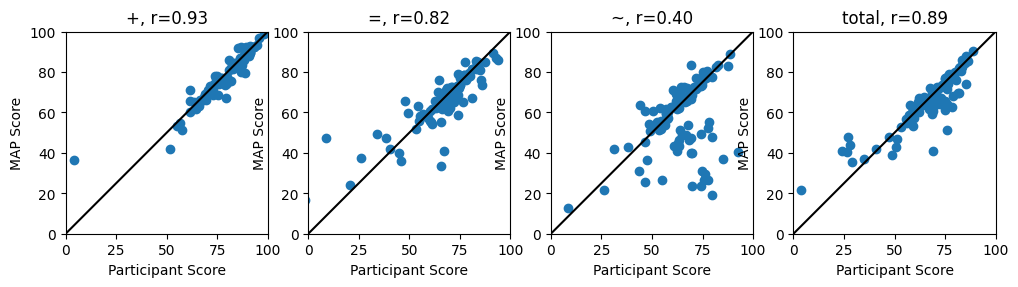

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(12,4))
ax = axes[0]
for ax, trial_type in zip(axes, ['+', '=', '~', 'total']):
    ax.plot(flkr_reses[trial_type].to_numpy().flatten(), flkr_reses[f'{trial_type}_map'].to_numpy().flatten(), 'o')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot([0,100], [0,100], color='black')
    ax.set_xlim((0, 100))
    ax.set_ylim((0, 100))
    r, _ = stats.pearsonr(flkr_reses[trial_type].to_numpy().flatten(),  flkr_reses[f'{trial_type}_map'].to_numpy().flatten())
    ax.set_title(f'{trial_type}, r={r:0.2f}')
    ax.set_xlabel('Participant Score')
    ax.set_ylabel('MAP Score')
    ax.set_aspect('equal')

In [11]:
flkr_params = ['r', 'p', 'sd0', 'K', 'L', 'thresh', 'alpha', 't0']
flkr_reses = flkr_reses.with_columns(
    pl.col(pp).alias(f'map__{pp}') for pp in flkr_params
)
flkr_reses.write_csv(results_dir.parent / 'flkr_results.csv')

In [12]:
len(flkr_reses)

100